In [1]:
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import os
import numpy as np

import time

import xarray as xr

from pathlib import Path 
import pathlib

import salvus.namespace as sn
from salvus.flow import simple_config as config

import salvus.mesh.unstructured_mesh as um
import salvus.mesh.structured_grid_2D as sg2d

from salvus.flow import simple_config as config
from salvus.toolbox import toolbox


import salvus.namespace as sn

import matplotlib.pyplot as plt

# Variable used in the notebook to determine which site
# is used to run the simulations.

#SALVUS_FLOW_SITE_NAME=os.environ.get('SITE_NAME','local')
SALVUS_FLOW_SITE_NAME=os.environ.get('eejit','eejit')

In [3]:
file = "vel1_copy.bin"

dt = np.dtype([('time', '<u2'),('time1', '<u2'),('time2', np.float32),('time3', np.float32)])

data = np.fromfile(file, dtype=np.float32, count=-1, sep='', offset=0)

my_array_rel_perm=data.reshape(3000,3000) 

#print( my_array_rel_perm)


In [4]:
#Make an array that has the same size as velocity
#Density constant ~ 1000 kg/m**3

my_array_rho=np.full((3000,3000),1000, dtype=int)
#print(my_array_rho)

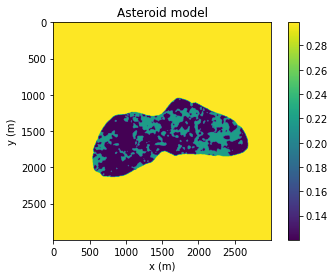

In [5]:
plt.imshow(np.rot90(my_array_rel_perm,3))
plt.title('Asteroid model')
plt.colorbar(orientation='vertical')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [6]:
def my_model():
    nx, nz = 3000, 3000
    x = np.linspace(-4000, +4000, nx)
    y = np.linspace(-4000, +4000, nx)
    xx, yy = np.meshgrid(x, y, indexing = "ij")
    
    #put the array elements into the appropriate part of the model xarray structure
    ds = xr.Dataset ( data_vars= {"vp": (["x", "y"], my_array_rel_perm),  "rho": (["x", "y"], my_array_rho),}, coords={"x": x, "y": y},)
    
    #Transform velocity to SI units (m/s).
    ds['vp'] *=10000

    return ds

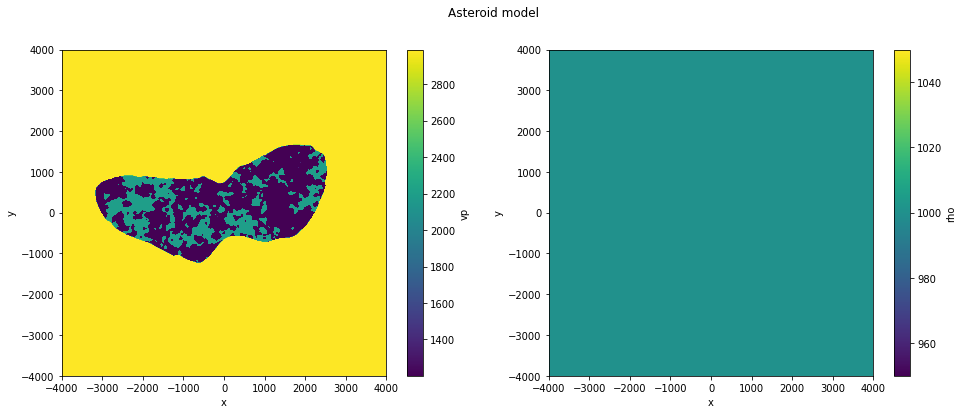

In [7]:
# Plot the xarray dataset.

true_model = my_model()

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.title("Asteroid model")
true_model.vp.T.plot()
plt.subplot(122)
true_model.rho.T.plot()
plt.suptitle("Asteroid model")
plt.show()

#### Stability Test

In [8]:
# Stability Test

dt = 0.02
dx = 1

eps  = my_array_rel_perm.min() * dt / dx

print('Stability criterion =', eps)

Stability criterion = 24.0162011719


In [9]:
test_Nyquist = 1 / (2*dt)

print(test_Nyquist)

25.0


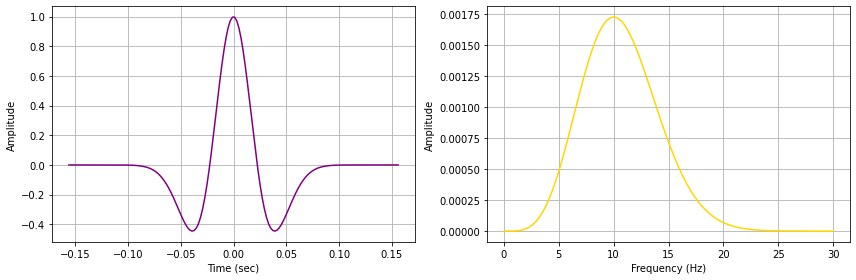

<class 'salvus.flow.simple_config.stf.Ricker'>


In [10]:
# Ricker wavelet 

wavelet = config.stf.Ricker(center_frequency=10.0)
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(*wavelet.get_stf(),color='purple')
ax[0].set_xlabel("Time (sec)")
ax[0].set_ylabel("Amplitude")

ax[1].plot(*wavelet.get_power_spectrum(), color='gold')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Amplitude")

ax[0].grid()
ax[1].grid()

plt.tight_layout()

plt.show()
print(type(wavelet))

In [11]:
# Create new Project

!rm -rf project
if pathlib.Path("project").exists():
    print("Opening existing project.")
    p = sn.Project(path="project")
else:
    print("Creating new project.")
    vm = sn.model.volume.cartesian.GenericModel(
        name="true_model_2", data=true_model
    )
    p = sn.Project.from_volume_model(path="project", volume_model=vm)

Creating new project.


In [12]:
wavelet=sn.simple_config.stf.Ricker(center_frequency=10.0)
mesh_frequency = 2 * wavelet.center_frequency


# Sources
srcs = sn.simple_config.source.cartesian.ScalarPoint2D( 
     source_time_function=wavelet, x=-100.0, y=3500.0, f=1)


# Receivers
recs = sn.simple_config.receiver.cartesian.collections.RingPoint2D(
        x=0, y=0, radius=3500, count=380, fields=["phi"])

    
p += sn.EventCollection.from_sources(sources=srcs, receivers=recs)

[2021-02-12 11:13:47,806] INFO: A source for event `event_0000` has a source time function. Events in the project cannot have a source time function (they are frequency dependent). The source time function has thus been stripped.


In [13]:
# Boundaries Conditions

num_absorbing_layers = 10
absorbing_side_sets = ["x0", "x1", "y0", "y1"]

# Create a mesh from xarray Dataset
mesh = toolbox.mesh_from_xarray(
    model_order=4,
    data=true_model,
    slowest_velocity="vp",
    maximum_frequency=mesh_frequency,
    elements_per_wavelength=1.5,
    absorbing_boundaries=(absorbing_side_sets, num_absorbing_layers)) 

In [14]:
# Visualize mesh
mesh

## Start Simulation

In [15]:
sim = config.simulation.Waveform (mesh=mesh,sources=srcs,receivers=recs)

## Create Snapshots

In [16]:
#sim.output.point_data.format = "hdf5"

In [17]:
# Save the volumetric wavefield for visualization purposes.
#sim.output.volume_data.format = "hdf5"
#sim.output.volume_data.filename = "New_model_vm.h5"
#sim.output.volume_data.fields = ["phi"]
#sim.output.volume_data.sampling_interval_in_time_steps = 10

In [18]:
sim.validate()

In [19]:
# Visualize Simulation
sim

In [20]:
# Waveform Simulation Configuration
wsc = sn.WaveformSimulationConfiguration(end_time_in_seconds=6.0)


In [21]:
# Event Configuration
ec = sn.EventConfiguration(
    waveform_simulation_configuration=wsc,
    wavelet=sn.simple_config.stf.Ricker(center_frequency=10.0),
)

# Simulation Configuration

p += sn.SimulationConfiguration(
    name="true_model_new",
    elements_per_wavelength=1.5,
    tensor_order=4,
    max_frequency_in_hertz=mesh_frequency,
    model_configuration=sn.ModelConfiguration(
        background_model=None, volume_models="true_model_2"
    ),
    # Potentially event dependent settings.
    event_configuration=ec,
)

In [22]:
p.simulations.launch(
    simulation_configuration="true_model_new",
    events=p.events.get_all(),
    site_name=SALVUS_FLOW_SITE_NAME,
    ranks_per_job=4,
    wall_time_in_seconds_per_job=1,

)

[2021-02-12 11:14:07,772] INFO: Creating mesh. Hang on.
[2021-02-12 11:14:19,797] INFO: Submitting job ...
[2021-02-12 11:14:19,871] WARNING - salvus.flow.sites.remote_io_site: Hostname 'eejit.geo.uu.nl' NOT found in the SSH config file.
[2021-02-12 11:14:19,872] WARNING - salvus.flow.sites.remote_io_site: Will fall back to default config.
[2021-02-12 11:14:19,875] WARNING - salvus.flow.sites.remote_io_site: Check the spelling in SSH and Salvus' site config.
Uploading 1 files...


mesh.h5: 0.00b [00:00, ?b/s]


🚀  Submitted job_2102121114870965_782cfa4714@eejit


1

In [23]:
p.simulations.query(block=True)

VBox()

[2021-02-12 11:17:19,524] WARNING - salvus.flow.sites.remote_io_site: Hostname 'eejit.geo.uu.nl' NOT found in the SSH config file.
[2021-02-12 11:17:19,526] WARNING - salvus.flow.sites.remote_io_site: Will fall back to default config.
[2021-02-12 11:17:19,528] WARNING - salvus.flow.sites.remote_io_site: Check the spelling in SSH and Salvus' site config.


True

In [24]:
p.simulations.get_mesh("true_model_new")

In [25]:
true_data = p.waveforms.get(
    data_name="true_model_new", events=p.events.get_all()
)

In [57]:
p.viz.nb.waveforms(
    data=["true_model_new"],
    receiver_field="phi",
)

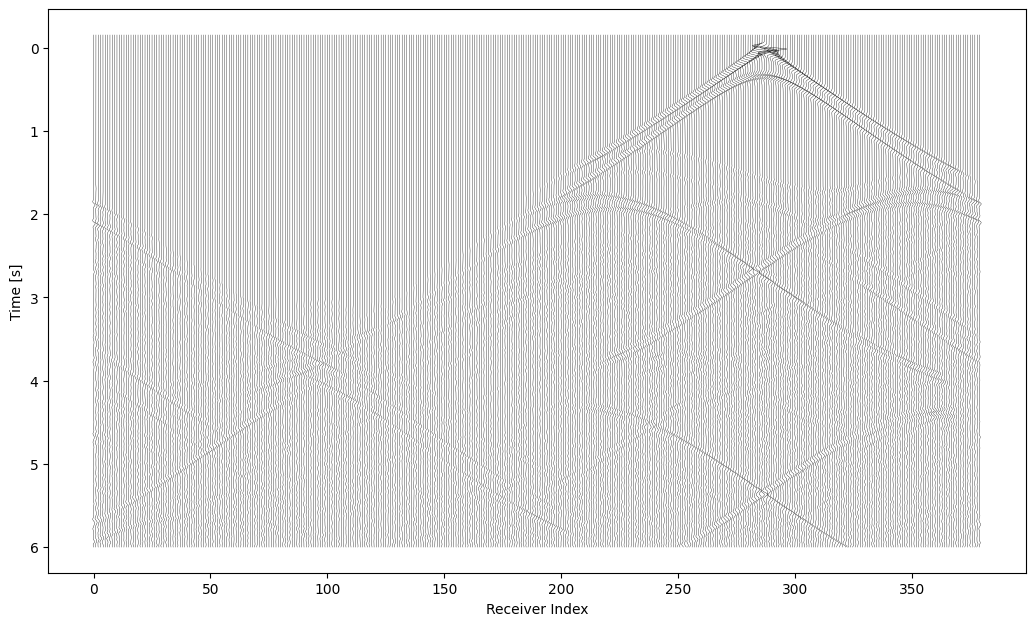

In [26]:
true_data[0].plot(component="A", receiver_field="phi")

## Reverse Time Migration

### Initial model

### We create a homogeneous background model and set up a simulation configuration that contains the same events as the true data.

In [47]:
def my_initial_model():
    nx, nz = 3000, 3000
    x = np.linspace(-4000, +4000, nx)
    y = np.linspace(-4000, +4000, nx)
    xx, yy = np.meshgrid(x, y, indexing = "ij")
    
    #put the array elements into the appropriate part of the model xarray structure
    ds = xr.Dataset ( data_vars= {"vp": (["x", "y"], my_array_rel_perm),  "rho": (["x", "y"], my_array_rho),}, coords={"x": x, "y": y},)
    
   #Transform velocity to SI units (m/s).
   #ds['vp'] *=10000

    return ds

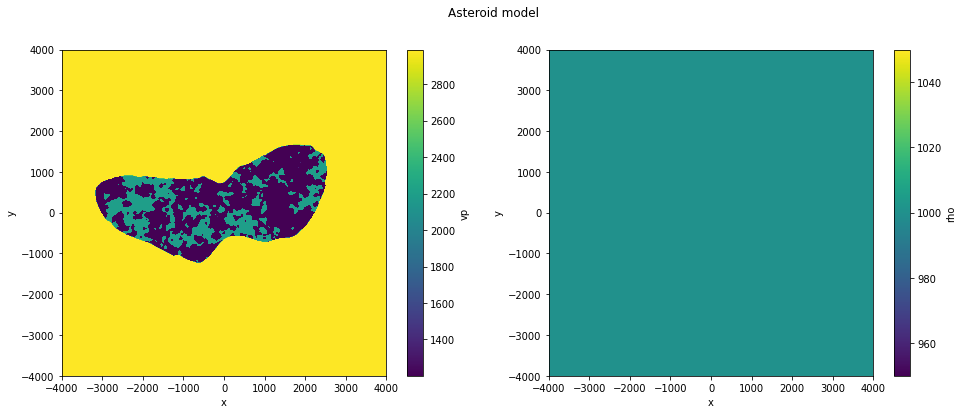

In [48]:
initial_model = my_initial_model()


#Plot the xarray dataset.
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.title("Asteroid model")
initial_model.vp.T.plot()
plt.subplot(122)
initial_model.rho.T.plot()
plt.suptitle("Asteroid model")
plt.show()

In [49]:

# Sources
srcs_1 = sn.simple_config.source.cartesian.ScalarPoint2D( 
    source_time_function=wavelet, x=-100.0, y=3500.0, f=1)


# Receivers
recs_1 = sn.simple_config.receiver.cartesian.collections.RingPoint2D(
        x=0, y=0, radius=3500, count=380, fields=["phi"])
    


In [53]:
initial_mesh = toolbox.mesh_from_xarray(
    model_order=4,
    data=initial_model,
    slowest_velocity="vp",
    maximum_frequency=mesh_frequency,
    elements_per_wavelength=1.5,
    absorbing_boundaries=(absorbing_side_sets, num_absorbing_layers)) 

In [54]:
initial_mesh

In [74]:
mesh_0 = toolbox.mesh_from_xarray(
    model_order=4,
    data=initial_model,
    slowest_velocity="vp",
    maximum_frequency=mesh_frequency,
    elements_per_wavelength=1.5,
    absorbing_boundaries=(absorbing_side_sets, num_absorbing_layers)) 

new_mesh = mesh_0.copy()

In [76]:

smoothing_length_in_meters = 5


new_mesh.attach_field("phi", np.ones_like(new_mesh.get_element_nodes()[:, :, 0]))
new_mesh.attach_field(
    "gradient_of_phi",
    0.5
    * smoothing_length_in_meters ** 2
    * np.ones_like(new_mesh.get_element_nodes()[:, :, 0]),
)
new_mesh.attach_field("phi", np.ones(new_mesh.nelem))
new_mesh

In [79]:
#true_data[0].plot(component="A", receiver_field="phi")

#synthetic_data[0].plot(component="A", receiver_field="phi")


In [80]:
#p.viz.nb.waveforms(
#    ["true_model_new", "initial_model"], receiver_field="phi")

In [38]:
# Misfit Configuration
#p += sn.MisfitConfiguration(
#    name="L2",
#    observed_data="true_model_new",
#    misfit_function="L2",
#    receiver_field="phi",
#)

In [81]:
#print(
#    p.actions.inversion.compute_misfits(
#        simulation_configuration="initial_model",
#        misfit_configuration="L2",
#        events=p.events.list(),
#        store_checkpoints=False,
#        site_name=SALVUS_FLOW_SITE_NAME,
#        ranks_per_job=4,
#    )
#)

In [82]:

#while not p.actions.inversion.compute_gradients(
#    simulation_configuration="initial_model",
#    misfit_configuration="L2",
#    events=p.events.list(),
#    site_name=SALVUS_FLOW_SITE_NAME,
#    ranks_per_job=4,
#):
#    time.sleep(1.0)

In [83]:
#p.viz.nb.gradients(
#    simulation_configuration="initial_model",
#    misfit_configuration="L2",
#    events=p.events.list(),
#)

In [84]:
#gradient = p.actions.inversion.sum_gradients(
#    simulation_configuration="initial_model",
#    misfit_configuration="L2",
#    events=p.events.list(),
#)
#gradient

In [85]:
#p.actions.inversion.smooth_model(
#    model=gradient,
#    smoothing_configuration=sn.ConstantSmoothing(
#        smoothing_lengths_in_meters={
#            "VP": 0.01,
#            "RHO": 0.01,
#        },
#    ),
#    ranks_per_job=4,
#    site_name=SALVUS_FLOW_SITE_NAME,
#)